# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import GEOparse as Geo
import seaborn as sns
from pandas.core.ops import comp_method_OBJECT_ARRAY
from collections import Counter

os.chdir('../../')
os.getcwd()

'/home/max/mcrc-cetuximab-analysis'

In [2]:
fpkms_df = pd.read_csv("raw/GSE183984_ASAN_RNASEQ_FPKM_ensg.csv", index_col=0).T
raw_counts_df = pd.read_csv("raw/GSE183984_ASAN_RNASEQ_raw_counts_ensg.csv", index_col=0).T

print(fpkms_df.shape)
print(raw_counts_df.shape)

# columns are the same in TPM and FPKM
print(set(fpkms_df.columns) - set(raw_counts_df.columns))
print(set(raw_counts_df.columns) - set(fpkms_df.columns))

# no duplicate column names
print(len(fpkms_df.columns), len(set(fpkms_df.columns)))
print(len(raw_counts_df.columns), len(set(raw_counts_df.columns)))

data_ensemble_genes = list(fpkms_df.columns)

# no transcript level distinction
cnt = Counter()
for gene in data_ensemble_genes:
    cnt[gene[3]] += 1
cnt

(113, 58735)
(113, 58735)
set()
set()
58735 58735
58735 58735


Counter({'G': 58735})

In [3]:
tpms_df = fpkms_df.T.div(fpkms_df.sum(axis=1)).T * 10 ** 6
tpms_df.sum(axis=1)

18R176_0020    1000000.0
18R177_0021    1000000.0
18R178_0022    1000000.0
18R296_0008    1000000.0
18R301_0002    1000000.0
                 ...    
18R309_0015    1000000.0
18R310_0016    1000000.0
18R311_0018    1000000.0
18R318_0005    1000000.0
18R319_0014    1000000.0
Length: 113, dtype: float64

In [4]:
def parse_gtf(gtf_path):
    ensemble_gene_id_to_length = Counter()
    ensemble_gene_id_to_version = dict()
    ensemble_gene_id_to_hgnc = dict()
    ensemble_gene_id_to_biotype = dict()
    with open(gtf_path, "r") as f:
        for li, line in enumerate(f):
            # print(line)
            if line.startswith("#"):
                continue
            
            parts = line.strip().split()
            chromosome = parts[0]
            entry_source_0 = parts[1]
            entry_type = parts[2]
            start = int(parts[3])
            end = int(parts[4])
            info = dict()
            for i in range(8, len(parts) - 1, 2):
                key = parts[i]
                val = parts[i + 1][1:-2]
                if key == 'gene_name' and val == 'havana':
                    print(key, val, i)
                info[key] = val
            
            if entry_type == 'gene' and 'gene_id' in info and 'gene_name' in info:
                ensemble_gene_id_to_hgnc[info['gene_id']] = info['gene_name']
                if 'gene_biotype' in info:
                    ensemble_gene_id_to_biotype[info['gene_id']] = info['gene_biotype']
            elif entry_type == 'exon':
                version = info['gene_version']
                ensemble_gene_id = info['gene_id']
                ensemble_gene_id_to_version[ensemble_gene_id] = version
                ensemble_gene_id_to_length[ensemble_gene_id] += int(parts[4]) - int(parts[3]) + 1
                    
    return ensemble_gene_id_to_hgnc, ensemble_gene_id_to_length, ensemble_gene_id_to_version, ensemble_gene_id_to_biotype

ensemble_gene_id_to_hgnc, ensemble_gene_id_to_length, \
 ensemble_gene_id_to_version, ensemble_gene_id_to_biotype = parse_gtf('data/Homo_sapiens.GRCh38.113.gtf')

In [5]:
print(len(ensemble_gene_id_to_hgnc.keys()))
print(len(ensemble_gene_id_to_biotype))
print(len(data_ensemble_genes))
print(len(set(ensemble_gene_id_to_hgnc.keys()) - set(data_ensemble_genes)))
print(len(set(data_ensemble_genes) - set(ensemble_gene_id_to_hgnc.keys())))

ensemble_genes_common = list(set(data_ensemble_genes).intersection(ensemble_gene_id_to_hgnc.keys()))
len(ensemble_genes_common)

42745
42745
58735
597
16587


42148

In [6]:
from collections import Counter

cnt = Counter()
hgnc_to_ensemble_set = dict()
# for key in ensemble_gene_id_to_hgnc:
for key in ensemble_genes_common:
    hgnc = ensemble_gene_id_to_hgnc[key]
    cnt[hgnc] += 1
    if cnt[hgnc] == 1:
        hgnc_to_ensemble_set[hgnc] = {key}
    else:
        hgnc_to_ensemble_set[hgnc].add(key)


In [7]:
parsed_hgncs = set(hgnc_to_ensemble_set.keys())
bg_hgncs = set(open('data/gene_lists/gnames.txt').read().strip().split())

print('Excess genes compared to BG list: ', len(parsed_hgncs - bg_hgncs))
print('Missing genes from BG list: ', len(bg_hgncs - parsed_hgncs))

common_hgncs = parsed_hgncs.intersection(bg_hgncs)
print('Common genes: ', len(common_hgncs))

Excess genes compared to BG list:  22540
Missing genes from BG list:  1657
Common genes:  18405


In [8]:
for key in common_hgncs:
    if len(hgnc_to_ensemble_set[key]) > 1 and key is not None:
        print(key)
        print([(egene, ensemble_gene_id_to_length[egene], ensemble_gene_id_to_biotype[egene], ensemble_gene_id_to_version[egene]) for egene in hgnc_to_ensemble_set[key]])

ELFN2
[('ENSG00000243902', 5718, 'lncRNA', '7'), ('ENSG00000166897', 11037, 'protein_coding', '16')]
PDE8B
[('ENSG00000284762', 3397, 'protein_coding', '1'), ('ENSG00000113231', 21876, 'protein_coding', '14')]
GOLGA8M
[('ENSG00000188626', 5932, 'protein_coding', '7'), ('ENSG00000261480', 557, 'lncRNA', '1')]
C4orf36
[('ENSG00000163633', 4881, 'protein_coding', '12'), ('ENSG00000285458', 3014, 'protein_coding', '1')]
POLR2J3
[('ENSG00000168255', 14603, 'protein_coding', '20'), ('ENSG00000285437', 10662, 'protein_coding', '2')]
MATR3
[('ENSG00000015479', 41180, 'protein_coding', '20'), ('ENSG00000280987', 23097, 'protein_coding', '4')]
SPATA13
[('ENSG00000228741', 1721, 'lncRNA', '2'), ('ENSG00000182957', 41488, 'protein_coding', '16')]
SIGLEC5
[('ENSG00000268500', 5713, 'protein_coding', '8'), ('ENSG00000105501', 553, 'lncRNA', '13')]
SFTA3
[('ENSG00000229415', 12669, 'lncRNA', '11'), ('ENSG00000257520', 2780, 'protein_coding', '2')]
PINX1
[('ENSG00000258724', 1753, 'protein_coding', '1

In [9]:
def process_columns(df, shrink_to_bg=False):
    print('Initial df cols: ', len(df.columns))
    df = df.drop(columns=list(set(df.columns) - set(ensemble_gene_id_to_hgnc.keys())))
    print('After dropping cols not annotated with HGNC name in GTF: ', len(df.columns))
    
    renamer = dict()
    for egene in ensemble_gene_id_to_hgnc:
        if ensemble_gene_id_to_biotype[egene] == 'protein_coding':
            renamer[egene] = ensemble_gene_id_to_hgnc[egene]

    df = df.rename(columns=renamer)
    df = df.drop(columns=[col for col in df.columns if col.startswith('ENSG')])
    
    print('After renaming to HGNC (and deleting non-protein coding egenes): ', len(df.columns))

    if shrink_to_bg:
        df = df[list(common_hgncs.intersection(df.columns))]
        print('After shrinking to BG HGNCs that are in the table: ', len(df.columns))
    
    mask = df.columns.duplicated()
    for i in range(len(mask)):
        if mask[i]:
            j = 0
            while df.columns[j] != df.columns[i]:
                j += 1
            df[df.columns[j]] += df[df.columns[i]]

    df = df.loc[:,~df.columns.duplicated()]

    print('After summing columns with the same HGNC name: ', len(df.columns))

    return df

raw_counts_df = process_columns(raw_counts_df)
fpkms_df = process_columns(fpkms_df)
tpms_df = process_columns(tpms_df)

Initial df cols:  58735
After dropping cols not annotated with HGNC name in GTF:  42148
After renaming to HGNC (and deleting non-protein coding egenes):  19394
After summing columns with the same HGNC name:  19388
Initial df cols:  58735
After dropping cols not annotated with HGNC name in GTF:  42148
After renaming to HGNC (and deleting non-protein coding egenes):  19394
After summing columns with the same HGNC name:  19388
Initial df cols:  58735
After dropping cols not annotated with HGNC name in GTF:  42148
After renaming to HGNC (and deleting non-protein coding egenes):  19394
After summing columns with the same HGNC name:  19388


In [10]:
print(tpms_df.sum(axis=1))
tpms_df = tpms_df.T.div(tpms_df.sum(axis=1)).T * 10 ** 6
print(tpms_df.sum(axis=1))

18R176_0020    299464.863171
18R177_0021    572690.867613
18R178_0022    588543.720858
18R296_0008    400006.551821
18R301_0002    361552.019798
                   ...      
18R309_0015    687089.826225
18R310_0016    334029.803449
18R311_0018    509640.971874
18R318_0005    257000.331800
18R319_0014    286719.825996
Length: 113, dtype: float64
18R176_0020    1000000.0
18R177_0021    1000000.0
18R178_0022    1000000.0
18R296_0008    1000000.0
18R301_0002    1000000.0
                 ...    
18R309_0015    1000000.0
18R310_0016    1000000.0
18R311_0018    1000000.0
18R318_0005    1000000.0
18R319_0014    1000000.0
Length: 113, dtype: float64


<Axes: xlabel='18R177_0021', ylabel='Count'>

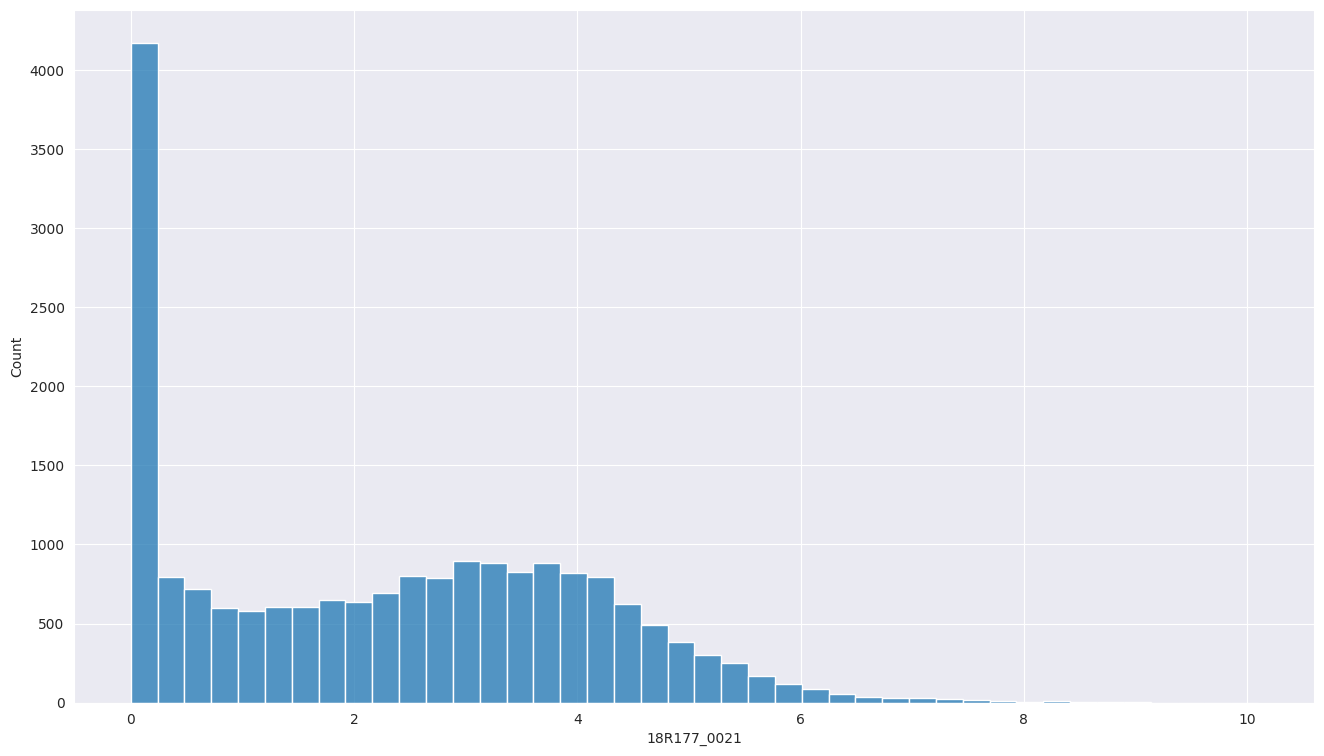

In [11]:
log_tpms_df = tpms_df.apply(lambda x: np.log(1 + x))
plt.figure(figsize=(16, 9))
sns.histplot(log_tpms_df.iloc[1])

<Axes: ylabel='Count'>

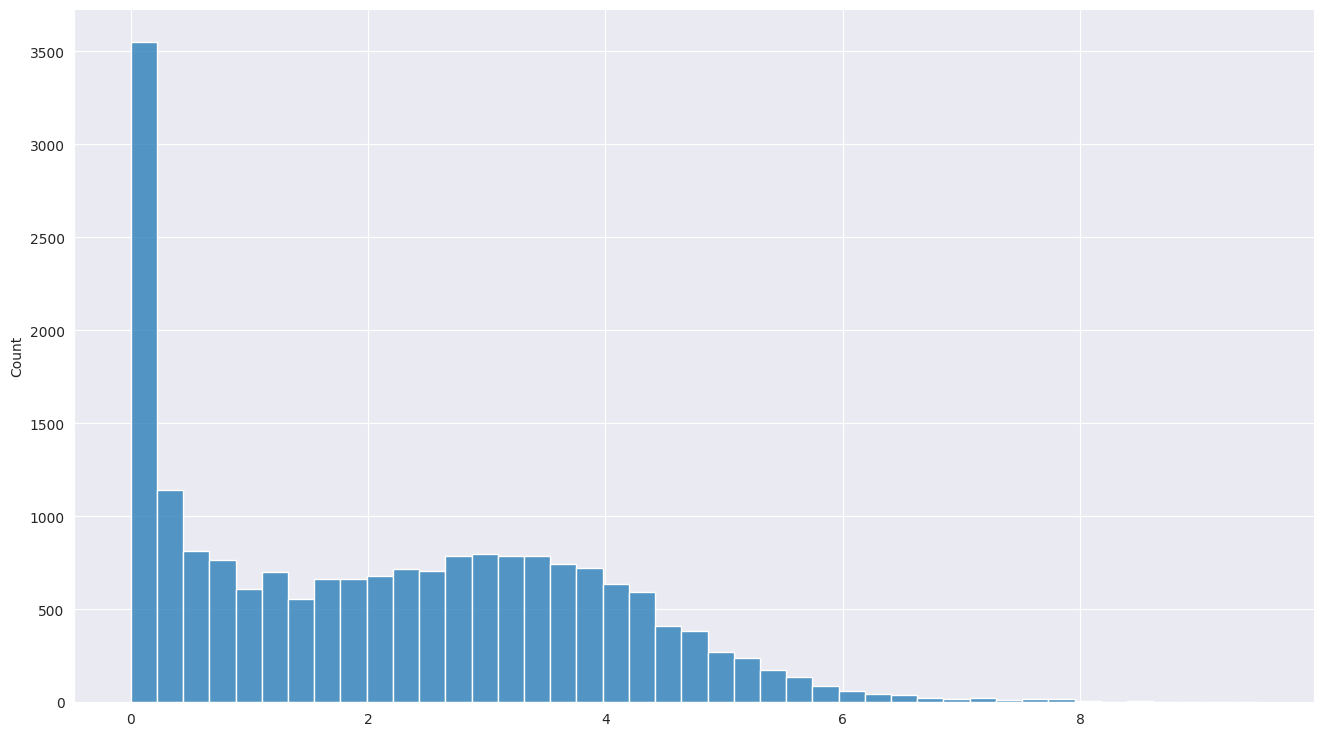

In [12]:
plt.figure(figsize=(16, 9))
sns.histplot(log_tpms_df.mean())

In [13]:
import pandas as pd

def extend_id(id):
    fp, sp = id.split('_')
    while len(sp) < 4:
        sp = '0' + sp
    return fp + '_' + sp

# Load annotation
ann = pd.read_csv("data/annotation_no_metastases.csv")
ann = ann.rename(columns={'Unnamed: 0': 'sample_id'})
ann['some_id'] = ann['some_id'].apply(extend_id) 

log_tpms_df['some_id'] = log_tpms_df.index
log_tpms_df.loc[:,'some_id'] = log_tpms_df['some_id'].apply(extend_id)
merged = log_tpms_df.merge(ann, on='some_id', how='inner')
log_tpms_df = merged[log_tpms_df.columns]
print(log_tpms_df)

      TSPAN6      TNMD      DPM1     SCYL3     FIRRM       FGR       CFH  \
0   4.378066  0.621373  6.391596  1.761371  2.928400  1.855207  3.727972   
1   3.931790  0.000000  5.471606  2.381998  2.784362  0.735446  3.788029   
2   3.933119  0.249772  6.144737  2.398256  3.554343  0.924366  3.797986   
3   5.272409  0.348340  6.203624  2.041960  2.771096  1.474633  3.963727   
4   4.716207  1.927777  5.798969  1.898107  3.240696  0.743111  3.899343   
..       ...       ...       ...       ...       ...       ...       ...   
80  4.038828  0.170060  5.921948  2.361361  3.192016  1.135749  3.724632   
81  4.166006  0.942684  6.338146  1.831406  2.803871  0.978470  4.089121   
82  5.007494  0.341777  6.249885  1.806112  2.959998  1.419991  4.504201   
83  2.932891  0.000000  6.012708  2.110488  3.483699  1.113839  3.537524   
84  4.322660  0.482590  6.074572  2.065969  3.436875  1.546580  4.573392   

       FUCA2      GCLC      NFYA  ...  FAM90A23  FAM90A14  GET1-SH3BGR  \
0   3.580593 

In [20]:
log_tpms_df = log_tpms_df.rename(columns={'some_id': 'sample_id'})

In [21]:
print(log_tpms_df)

      TSPAN6      TNMD      DPM1     SCYL3     FIRRM       FGR       CFH  \
0   4.378066  0.621373  6.391596  1.761371  2.928400  1.855207  3.727972   
1   3.931790  0.000000  5.471606  2.381998  2.784362  0.735446  3.788029   
2   3.933119  0.249772  6.144737  2.398256  3.554343  0.924366  3.797986   
3   5.272409  0.348340  6.203624  2.041960  2.771096  1.474633  3.963727   
4   4.716207  1.927777  5.798969  1.898107  3.240696  0.743111  3.899343   
..       ...       ...       ...       ...       ...       ...       ...   
80  4.038828  0.170060  5.921948  2.361361  3.192016  1.135749  3.724632   
81  4.166006  0.942684  6.338146  1.831406  2.803871  0.978470  4.089121   
82  5.007494  0.341777  6.249885  1.806112  2.959998  1.419991  4.504201   
83  2.932891  0.000000  6.012708  2.110488  3.483699  1.113839  3.537524   
84  4.322660  0.482590  6.074572  2.065969  3.436875  1.546580  4.573392   

       FUCA2      GCLC      NFYA  ...  FAM90A23  FAM90A14  GET1-SH3BGR  \
0   3.580593 

In [22]:
log_tpms_df.to_csv('data/log_tpms_from_fpkm_hgnc_no_metastases_maxim.csv')